<a id='Homework'></a>
# Homework

Theory (5 points):
- Complete theory questions in Google Form
- Take a look at all the links 
- Read and analyze all theory `TODO`s

Practice (10 points):
1. Take 2-3 channels from `KyivChannels_Dataset_v01`
2. Apply Clustering OR/AND Topic Modelling techniques to find topics of these channels. Ideal output: `channel_name:[topic_1, topic_2, topic_3]`. Examples: `Крипта Миколи : [криптовалюта, біржа]`
3. (Advanced) Try to come up with a universal approach
4. (Advanced) Apply your approach on other channels

Here is a list of standard topics for TG channels (from TGStat). In the best-case scenario use them as topics.
`topics.csv`

### Notes

1. For standard topics: execute clastering and try to match topics to ones in the list (perhaps create embeddings and use cosine similarity)
1. For automation:  create incapsulated class for topics modeling

## Imports

In [10]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="5"
# os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models
import langid
import random
import seaborn as sns

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

tqdm.pandas()

%matplotlib inline

## Load and pre-process data

In [3]:
# df = pd.read_csv("../data/kyiv-channels-dataset/KyivChannels_Dataset_v01.csv")
df = pd.read_csv("../data/kyiv-channels-dataset/KyivChannels_Dataset_v01_lang.csv", converters={"Date": pd.to_datetime})

### More precise language detection

Let's briefly inspect provided languages data

In [ ]:
df['lang'].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

In [15]:
df[df['lang'] == 'en']

,channelname,Date,content,lang
271,lossolomas_kyiv,2023-08-01 01:52:23,-246.690,en
790,lossolomas_kyiv,2023-08-02 01:37:25,-247.230,en
889,lossolomas_kyiv,2023-08-02 17:12:20,@lossolomas_kyiv,en
1081,lossolomas_kyiv,2023-08-03 02:15:20,-247.850,en
1297,lossolomas_kyiv,2023-08-03 15:47:36,😂😂😂\n\n@lossolomas_kyiv,en
...,...,...,...,...
30069,lossolomas_kyiv,2023-10-24 01:57:49,-295.510,en
30582,dailykek,2023-10-25 06:09:51,https://kvd.page.link/efeERSYLXeDNBA9M8,en
30710,lossolomas_kyiv,2023-10-25 02:27:21,-296.310,en
30904,lossolomas_kyiv,2023-10-26 01:57:26,-297.120,en


In [14]:
df[(df['lang'] == 'en') & (df['content'].str.len() > 50)]

,channelname,Date,content,lang
7200,tsegla_news,2023-08-20 07:30:26,https://www.the-village.com.ua/village/city/ci...,en
7897,maxbakhmatov,2023-08-22 04:46:08,https://www.youtube.com/live/g_HeXNvp_Rk?featu...,en
11863,dailykek,2023-09-02 21:27:01,We need an M1 Abrams Main Battle Tank to imple...,en
12088,lossolomas_kyiv,2023-09-03 15:56:37,https://www.facebook.com/groups/lossolomas/per...,en
16102,tsegla_news,2023-09-15 02:44:43,https://kmr.gov.ua/uk/content/proekt-rishennya...,en
18338,khreschatyk36,2023-09-21 16:56:25,"Mr. Presidents and your first ladies, you are ...",en
20126,tsegla_news,2023-09-26 06:27:15,https://www.facebook.com/100001611973752/posts...,en
24272,dailykek,2023-10-07 20:00:09,"Today, since morning, I have been in constant ...",en


In [18]:
print(df.loc[24272, "content"])

Today, since morning, I have been in constant contact with our diplomats and intelligence. Due to the terrorist attack on Israel and the threat to our citizens in Israel, an operational headquarters has been established under the Ministry of Foreign Affairs of Ukraine. 

As of now, the information about the possible death of one Ukrainian citizen is being verified and the search for two of our citizens is underway. Please, dear Ukrainians, if you are in Israel now, be as careful as possible. Follow the instructions of the security forces and take care of yourself and others around you. If you need anything, please contact our embassy by any means available to you – Ukraine will help all its people, no matter what.

Today, the whole world has seen horrific footage from Israel – footage of terrorists abusing women and men, taking even the elderly hostage without mercy... 

Today's terrorist attack on Israel was thoroughly prepared, and the whole world understands which terror sponsors co

We indeed have some posts in english

In [21]:
df[df['lang'] == 'bg'].head(30)

,channelname,Date,content,lang
454,ushkiklichko,2023-08-01 17:59:03,👂Уши Кличко НЕ идут на метро Университет.,bg
1913,kyiv_n,2023-08-05 13:18:51,"Швидкісна ракета - Київщина, — ПС\n\n🇺🇦 Киев С...",bg
1927,kyivpolitics,2023-08-05 09:53:30,⚡️Усложнение движения на Столичном шоссе со ст...,bg
3335,kyivpolitics,2023-08-09 11:42:00,❗️Снова МиГ-31К\n\nКиев. Главное. Политика,bg
3461,kyivpolitics,2023-08-09 09:25:02,"Когда удача не на твоей стороне, а карма догон...",bg
3641,khreschatyk36,2023-08-10 06:07:11,Профилактика нардепов от Арахамии в действии.,bg
3810,ushkiklichko,2023-08-10 15:50:29,"👂Ой, Кличко не заметил.",bg
4248,kyivpolitics,2023-08-11 12:37:57,Горит заброшенное здание возле ЖК Династия\n\n...,bg
4565,ushkiklichko,2023-08-12 17:24:02,👂Кличко как всегда ниче не знал 🤣,bg
4719,khreschatyk36,2023-08-13 10:55:59,"Директорка департаменту спорту КМДА Юля Хан, п...",bg


And this looks like clear missclassifications. Since all given telegram channels are Kyiv publics, I guess it's safe to assume that their language is either ukrainian, english or russian. Let's perform the same language detection, but with bounding possible scope to these three.

In [25]:
langid.set_languages(["uk", "ru", "en"])
df["lang"] = df["content"].progress_apply(lambda x: langid.classify(x)[0])

  0%|          | 0/31182 [00:00<?, ?it/s]

In [26]:
df['lang'].value_counts()

lang
uk    28603
ru     2379
en      200
Name: count, dtype: int64

In [28]:
df.to_csv("../data/kyiv-channels-dataset/KyivChannels_Dataset_v01_lang.csv", index=None)

### Text cleaning

In [4]:
import emoji

In [5]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def remove_emojis(text):
    return ''.join(char for char in text if not emoji.demojize(char).strip(':'))

def process_text(input):
    if isinstance(input, str):
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        input = remove_emojis(input)
    return input

df["content_processed"] = df["content"].progress_apply(process_text)

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_3441218/463847842.py:3: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


  0%|          | 0/31182 [00:00<?, ?it/s]

### Date dependency

In [6]:
df['Date_day'] =  df['Date'].dt.date

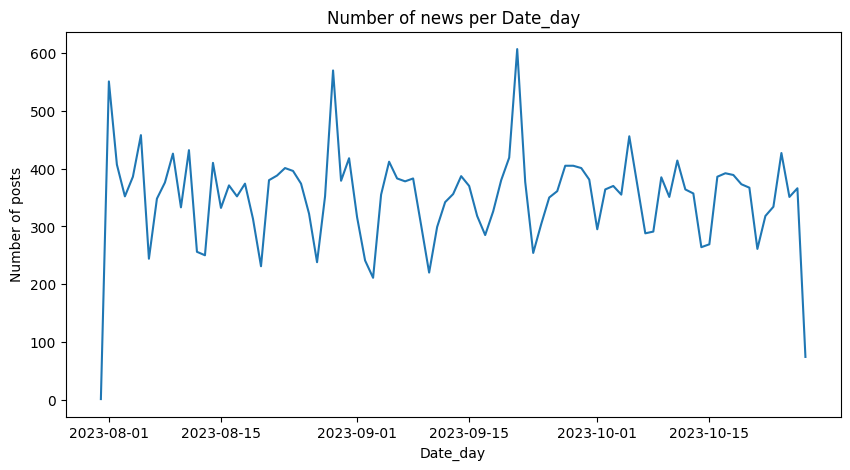

In [27]:
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

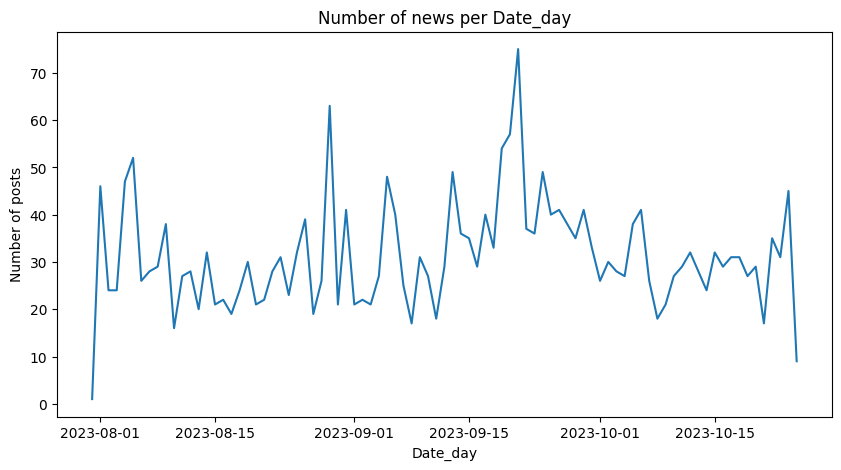

In [26]:
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
df[df['channelname'] == 'darnicalive'].groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

<Axes: xlabel='Date_day', ylabel='content'>

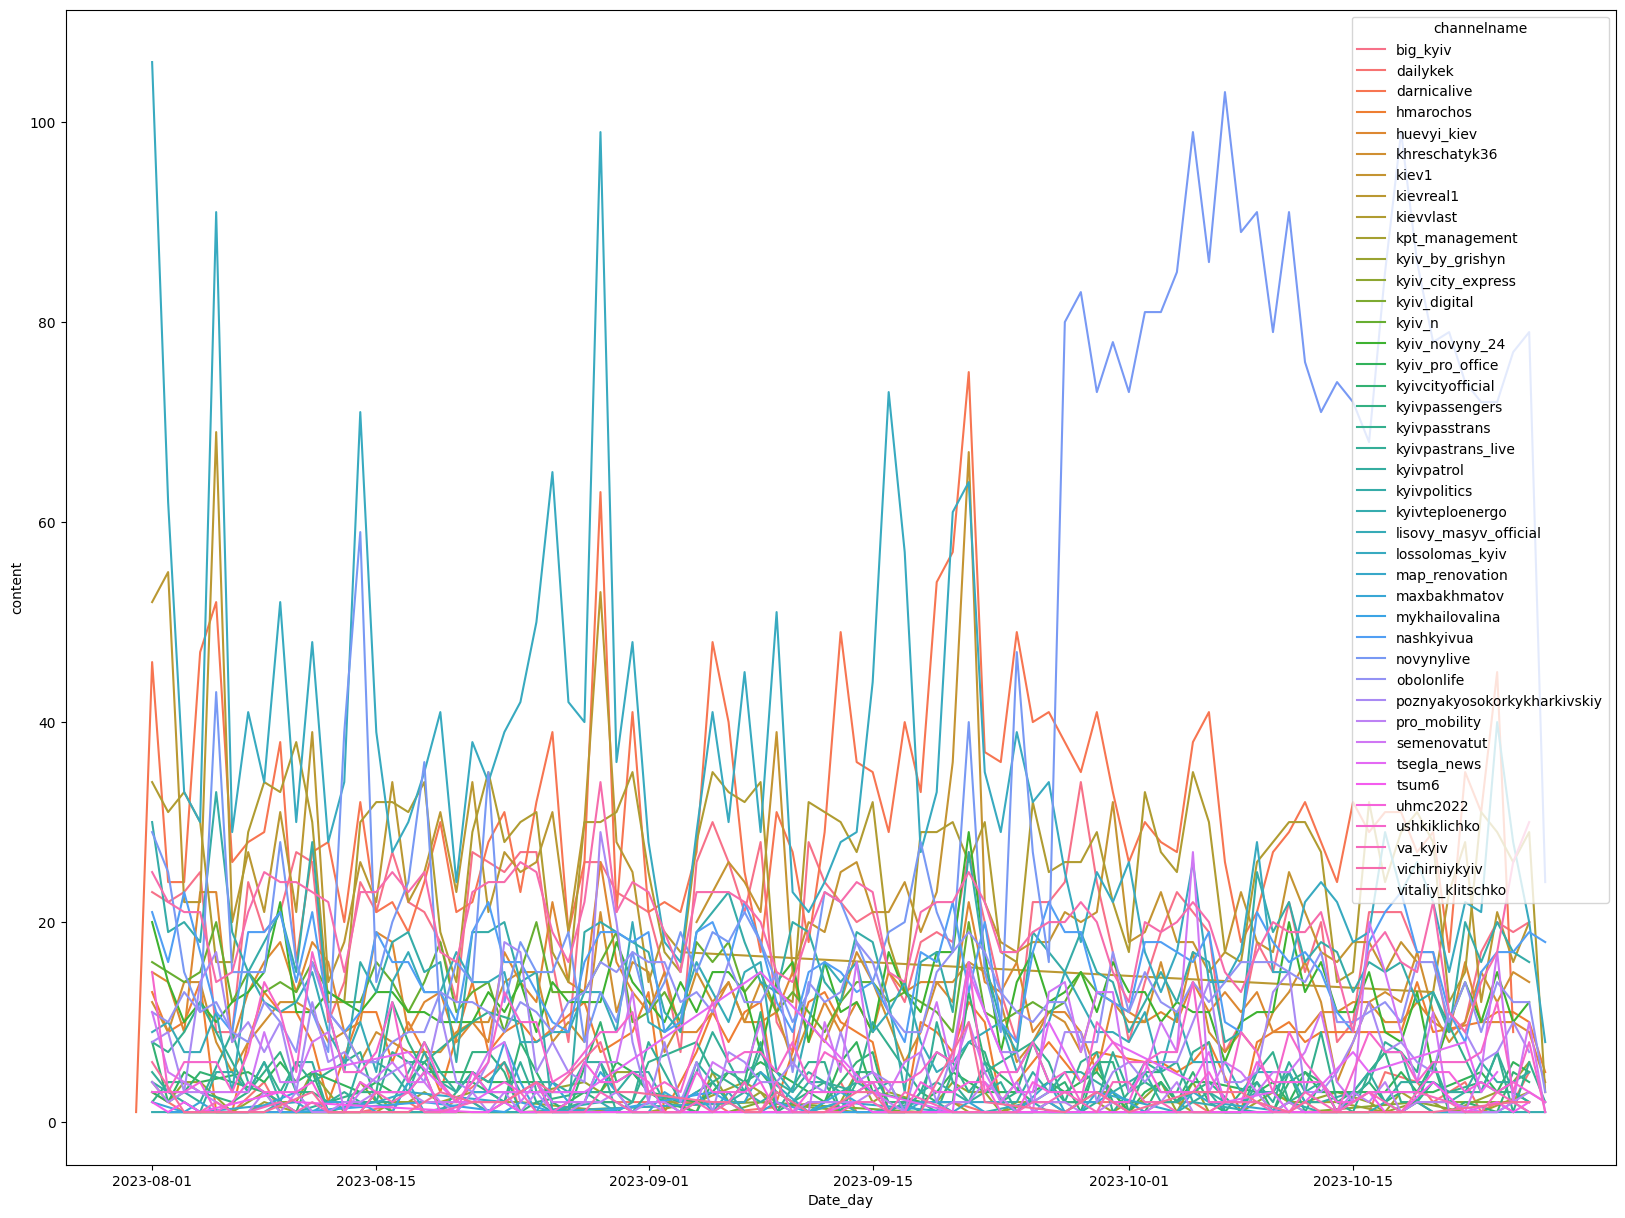

In [23]:
plt.figure(figsize=(20, 15))
sns.lineplot(data=df.groupby(["channelname", "Date_day"]).count(), x="Date_day", y="content", hue="channelname")

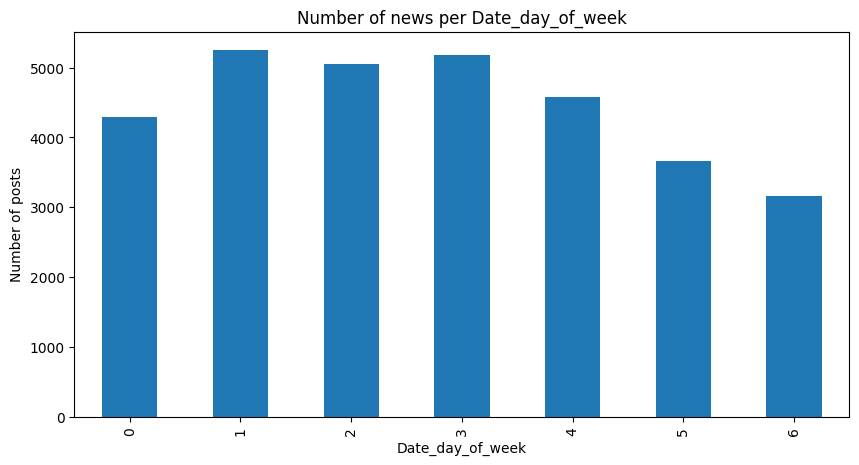

In [9]:
df['Date_day_of_week'] = df['Date'].dt.day_of_week

plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day_of_week")
df.groupby("Date_day_of_week")["content"].count().plot.bar()
plt.xlabel("Date_day_of_week")
plt.ylabel("Number of posts")
plt.show()

## Topic modeling

### Set of topics

In [79]:
import translators as ts
import time
import re

In [44]:
topics = pd.read_csv("../data/kyiv-channels-dataset/topics.csv")

In [49]:
topics.sample(5)

,topic_en
35,Psychology
19,Games
25,Law
15,Esoterics
33,Pictures and photos


In [85]:
def translate_topic(name, to_lang):
    text = ts.translate_text(
        f"""Among others, one of popular topics for posts in social media is "{name}" """, 
        translator="google", 
        to_language=to_lang
    )
    text = re.sub(r"[«]|[»]", '"', text)
    res = text.split('"')[1]
    time.sleep(0.1)
    return res

In [70]:
topics['topic_uk'] = topics['topic_en'].progress_apply(translate_topic, args=('uk', ))

  0%|          | 0/47 [00:00<?, ?it/s]

In [86]:
topics['topic_ru'] = topics['topic_en'].progress_apply(translate_topic, args=('ru', ))

  0%|          | 0/47 [00:00<?, ?it/s]

In [87]:
topics

,topic_en,topic_uk,topic_ru
0,Adult,дорослий,взрослый
1,Art,мистецтво,искусство
2,Blogs,блоги,блоги
3,Bookmaking,книжковий створення,Буквафика
4,Books,книги,книги
5,Business and startups,бізнес та стартапи,бизнес и стартапы
6,Career,кар'єра,Карьера
7,Courses and guides,курси та путівники,курсы и гиды
8,Cryptocurrencies,криптовалюти,криптовалюты
9,Darknet,Darknet,Darknet


In [89]:
topics.to_csv("../data/kyiv-channels-dataset/topics_googletr.csv", index=None)

Not very good results with google translate, even with context prompt. `"работа по рук"`, really?)

To avoid fixing all mistakes by hands, I also tried to do the same with chatgpt.

I used the following prompt for ukrainian topics:

> You will be given a list of English names of popular topics for posts on social media. For each topic choose the most suitable analog in Ukrainian and output a list of names of topics in Ukrainian in the same format. Try to come up with the closest in meaning one, not necessarily keeping the same word number.
> For example, "Adult" can be translated as "Контент для дорослих"


In [96]:
topics_uk = ["Дорослий контент", "Мистецтво", "Блоги", "Ставки", "Книги", "Бізнес та стартапи", "Кар'єра", "Курси та посібники", "Криптовалюти", "Темний інтернет", "Дизайн", "Економіка", "Освіта", "Навчально-розважальний контент", "Еротика", "Езотерика", "Сім'я та діти", "Мода та краса", "Їжа та кулінарія", "Ігри", "Рукоділля", "Здоров'я та фітнес", "Гумор та розваги", "Інстаграм", "Дизайн та будівництво", "Право", "Лінгвістика", "Маркетинг, PR, реклама", "Медицина", "Музика", "Природа", "Новини та медіа", "Інше", "Зображення та фотографії", "Політика", "Психологія", "Цитати", "Релігія", "Продажі", "Шоковий контент", "Програмне забезпечення та додатки", "Спорт", "Технології", "Телеграм", "Транспорт", "Подорожі", "Відео та фільми"]
topics_ru = ["Для взрослых", "Искусство", "Блоги", "Ставки", "Книги", "Бизнес и стартапы", "Карьера", "Курсы и руководства", "Криптовалюты", "Темный интернет", "Дизайн", "Экономика", "Образование", "Образовательный контент", "Эротика", "Эзотерика", "Семья и дети", "Мода и красота", "Еда и кулинария", "Игры", "Рукоделие", "Здоровье и фитнес", "Юмор и развлечения", "Инстаграм", "Интерьер и строительство", "Право", "Лингвистика", "Маркетинг, PR, реклама", "Медицина", "Музыка", "Природа", "Новости и медиа", "Прочее", "Картинки и фотографии", "Политика", "Психология", "Цитаты", "Религия", "Продажи", "Шок-контент", "Программное обеспечение и приложения", "Спорт", "Технологии", "Телеграм", "Транспорт", "Путешествия", "Видео и фильмы"]

In [97]:
topics['topic_uk'] = topics_uk
topics['topic_ru'] = topics_ru

In [98]:
topics.to_csv("../data/kyiv-channels-dataset/topics_chatgpt.csv")

In [99]:
topics

,topic_en,topic_uk,topic_ru
0,Adult,Дорослий контент,Для взрослых
1,Art,Мистецтво,Искусство
2,Blogs,Блоги,Блоги
3,Bookmaking,Ставки,Ставки
4,Books,Книги,Книги
5,Business and startups,Бізнес та стартапи,Бизнес и стартапы
6,Career,Кар'єра,Карьера
7,Courses and guides,Курси та посібники,Курсы и руководства
8,Cryptocurrencies,Криптовалюти,Криптовалюты
9,Darknet,Темний інтернет,Темный интернет


> **ToDO** Generate keywords for topics for better embeddings 


#### Topics embeddings

In [32]:
topics = pd.read_csv("../data/kyiv-channels-dataset/topics_chatgpt.csv")

In [30]:
# sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device="cuda",)
sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

In [39]:
topics_emb = {}

for lang in ['uk', 'en', 'ru']:
    topics_emb[lang] = sent_emb_model.encode(topics[f'topic_{lang}'], show_progress_bar=True)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

### Topics detection

In [117]:
class ChannelTopics():
    def __init__(self, df_channel, topics_df=topics) -> None:
        self.model = BERTopic(
            embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
        )
        self.df = df_channel
        self.lang = self.df['lang'].value_counts().index[0]

    def get_topics(self):
        pass

In [118]:
channel_topics = {}

for channelname in tqdm(df['channelname'].unique()):
    channel_topics[channelname] = ChannelTopics(df_channel=df[df['channelname'] == channelname].copy())

  0%|          | 0/41 [00:00<?, ?it/s]

In [119]:
channel_topics['kyiv_by_grishyn'].lang

'uk'